In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import models 
import numpy as np
import matplotlib.pyplot as plt 

/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sean/anaconda3/envs/tf-gpu-c

Previous networks have been classification problems, where you are mapping inputs into discrete outputs. This example is a continuous input to contiuous output, more relevant to masters proj.#

Example is Boston House Prices
Data set is v different to previous text and image inputs.  \
each feature in the dataset has different range, ie some are $0<x_1<1$ and some are $0<x_2<100$.

In [2]:
from tensorflow.keras.datasets import boston_housing 

In [3]:
(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

In [4]:
train_data.shape
test_data.shape

(102, 13)

In [5]:
print(train_targets[:10])
#House Price in Thousands of dolla 

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


In [6]:
print(np.average(train_targets*1.0557**(2021-1970)))
## humm some dodgy maths but thats a lot

355.4009841612698


Because the input data has different ranges, normalising it by  \
$new_{data} = \frac{data -mean}{std}$

In [7]:
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis= 0)
train_data /= std

test_data -= mean
test_data /= std

Never use any quantity calculated on the test data, I think will effect how easily detected overfitting is

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers 

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation= 'relu',input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop',loss = 'mse', metrics = ['mae'])
    return model

Here I have used loss of mean square error, 'widely used for regression problems'
Metric cant be acc, now it is Mean Absolute Error

## K-Fold Validation 
because the dataset in this example is so small, if you were to batch it up to have a training and validation set, you would have shit all left to play with. \
With K-Fold validation data is partitioned up into 4/5 blocks, you cycle through the blocks leaving one for validation and the other 3/4 for testing this then produces 4/5 validation results.(the / is an or) Take a mean of these and this is the validation result. 

In [11]:
k = 4 
num_val_samples = len(train_data)//k #// rounds to nearest lower integer that divides cleanly 
num_epoch =100
all_scores = []


for i in range(k):
    print('Processing Fold #',(i+1))
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]


    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis = 0)
    model = build_model()

    model.fit(partial_train_data,partial_train_targets, epochs = num_epoch,batch_size = 1,verbose= 0)
    val_mse,val_mae = model.evaluate(val_data,val_targets,verbose= 0)
    all_scores.append(val_mae)


Processing Fold # 0
Processing Fold # 1
Processing Fold # 2
Processing Fold # 3


In [13]:
print(all_scores)
print(np.mean(all_scores))

[2.0391169, 2.7335644, 2.738323, 2.5086215]
2.5049064


as can be seen above variance is quite high on this data, $2.5 on houses in the 10-50k range. It is worth plotting MAE further 

In [15]:
num_epoch = 500
all_mae_histories = [] 
for i in range(k):
    print('Processing fold #',(i+1))
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]

    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis = 0)
    
    
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,validation_data= (val_data,val_targets), epochs = num_epoch,batch_size = 1,verbose= 0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

Processing fold # 1
Processing fold # 2
Processing fold # 3
Processing fold # 4


Text(0, 0.5, 'Validation Mean Absolute Error')

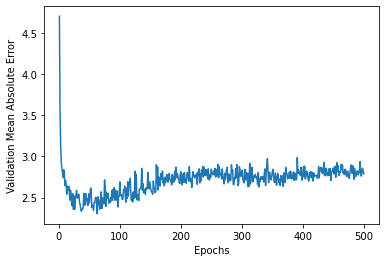

In [19]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epoch)]
##Plotting
plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Mean Absolute Error')

Signal is very noisy, take moving average, and get rid of first ten epoch

Text(0, 0.5, 'Validation Mean Absolute Error ')

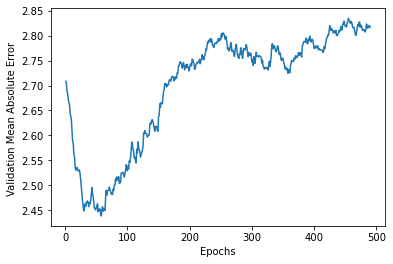

In [21]:
def smooth_curve(points,factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smoothed_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smoothed_mae_history)+1),smoothed_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Mean Absolute Error ')

Over Fitting begins after 80 ish epoch
